# Train predicator (classifier) for AFA 
The AFA problem contains the training of a classifier that is able to predict well based on any acquired subset of features. 
In this notebook we train and save such a classifier 

## Define paths

In [1]:
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# name for predictor 
predictor_model_name  = 'logistic_regression'

In [2]:
# specifications
data_dir       = "../../../data/ts/" + dataset_name + "/" + miss_scenario + "/" 
data_file          = data_dir + dataset_name + '_' + miss_scenario + '_static.csv.gz' 
temporal_data_file = data_dir + dataset_name + '_' + miss_scenario + '_ts_eav.csv.gz' 
superfeature_mapping_file = data_dir + 'superfeatures.csv'
problem_file   = data_dir + 'problem/' + 'problem.yaml'
afa_problem_files = {
        'action_file'          : data_dir + 'afa_problem/' + 'acquisition_actions.csv', 
        'prediction_cost_file' : data_dir + 'afa_problem/' + 'prediction_cost.csv'
                }
folds_file = data_dir + 'folds/' + 'fold_list.hkl'


# define files needed to load missingness model
miss_model_files = {
    'm_graph_adj_file' : data_dir + '/' + 'm_graphs/' + 'm_graph_adjacencies.csv'
    }

# new (where to save the model) 
predictor_model_dir = data_dir + 'predictor_models' + '/' + predictor_model_name + '/'

# reporting
explanation_file = predictor_model_dir +  'reports/' + 'model_report' 

### Imports 

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

# navigate to afa directory 
sys.path.insert(0, os.path.abspath('../../afa'))

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [4]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-02-05 22:34:58.719147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 22:34:58.874020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 22:34:58.874039: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 22:34:59.627877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
data_loader = DataLoader_ts( data_file                  = data_file,
                             temporal_data_file         = temporal_data_file,
                             superfeature_mapping_file  = superfeature_mapping_file,
                             problem_file               = problem_file,
                             afa_problem_files          = afa_problem_files, 
                             miss_model_files           = miss_model_files,
                             folds_file                 = folds_file)
dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 679.88it/s]


## Create afa dataset with missingness 
To train an AFA predictor, we need to induce artificial missingness (such that the predictor is robust to the missingness pattern). 
Here, we use a simple model to create missingness randomly.

In [6]:
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_ts import MissingDataGraph_ts
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_ts import PropensityScoreModel_ts
from afa_models.afa_agents.afa_mechanism_agents.afa_mechanism_agent import AFAMechanismAgent

### Define Missingness Model

In [46]:
import pandas as pd
import numpy as np 
# simple MCAR model 
m_graph_adj = pd.DataFrame([[0, 0], [0, 0]], 
                            index=['X0_ts', 'X1_ts' ], 
                            columns=['R_superX1_ts', 'R_superX2_ts'])
m_graph     = MissingDataGraph_ts(   m_graph_adj  = m_graph_adj ) 

weights_df  = pd.DataFrame([[0.9, 0.9],[np.nan, np.nan],[np.nan, np.nan]], 
                        index   = ['bias', 'X0_ts',  'X1_ts'], 
                        columns = ['R_superX1_ts', 'R_superX2_ts'])


ps_model_params = {}
ps_model_params['base_model_params'] = {  'base_model_type': 'stationary_constant',
                                          'gt_weights': weights_df }

ps_model_name = 'dummy_miss_model'
ps_model = PropensityScoreModel_ts(     name            = ps_model_name, 
                                        m_graph         = m_graph, 
                                        feature_name    = dataset.feature_name,
                                        target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                        model_params = ps_model_params ) 

afa_agent = AFAMechanismAgent(  name    = miss_scenario + '_agent',
                                ps_model= ps_model 
                             )

Change base_model to stationary_constant
Change base_model to stationary_constant
Set weight for constant stationary model ...
Set weight for constant stationary model ...


### Create AFADataset

In [47]:
from afa_datasets.afa_dataset_ts import AFADataset_ts

In [48]:
afa_results = afa_agent.predict(dataset, ids = None, fold = None, split = None,  n_samples = 10) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_ts(  dataset = dataset, model = afa_agent, results = afa_results) 

## Train Predictor 

### Initialize predictor 

In [49]:
from afa_models.afa_predictors.afa_predictor_ts import AFAPredictor_ts

In [50]:
predictor_model_params = {
    'name' : predictor_model_name, 
    'base_model_params' : {   'base_model_type': 'ImputeThenRegress',
                              'imputer_params' : 
                                       {   
                                      'base_model_type': 'simple_imputer',
                                      'mode' : 'imputation', 
                                      'checkpoint_dir': predictor_model_dir + 'checkpoints/' 
                                      },
                              'predictor_params' : 
                                       {   
                                      'base_model_type': 'ann',
                                      'mode' : 'classification', 
                                      'units':              1,
                                      'layers': 1,
                                      'learning_rate': 0.01,
                                      'batch_size' :128,
                                      'epochs': 100,
                                      'checkpoint_dir': predictor_model_dir + 'checkpoints/' 
                                      }
                          }
    }

In [51]:
afa_predictor = AFAPredictor_ts(    name            = predictor_model_name, 
                                    model_params     = predictor_model_params)  

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...


Epoch 1/100
6/6 [==============================] - 1s 27ms/step - loss: 0.5610 - binary_accuracy: 0.7125 - val_loss: 0.4580 - val_binary_accuracy: 0.8125
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5591 - binary_accuracy: 0.7125 - val_loss: 0.4583 - val_binary_accuracy: 0.8125
Epoch 3/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5558 - binary_accuracy: 0.7097 - val_loss: 0.4595 - val_binary_accuracy: 0.8125
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5531 - binary_accuracy: 0.7069 - val_loss: 0.4609 - val_binary_accuracy: 0.7750
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5507 - binary_accuracy: 0.7069 - val_loss: 0.4627 - val_binary_accuracy: 0.7750
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5492 - binary_accuracy: 0.7028 - val_loss: 0.4648 - val_binary_accuracy: 0.7875
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5473 - b

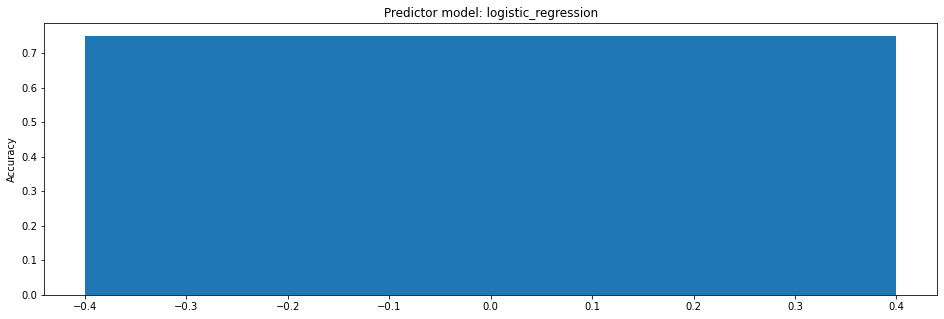

In [52]:
afa_predictor.fit(afa_dataset, 
                  fold = 0, 
                  train_split = 'train', 
                  valid_split = 'val', 
                  fit_again = True)